In [ ]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('./drive/MyDrive/nixtlats')
# print(os.getcwd())

In [ ]:
# !pip install pytorch-lightning
# !pip install torchinfo
# !pip install fastcore
# !pip install s3fs
# !pip install patool

In [ ]:
# default_exp models.nbeats.nbeats

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# N-BEATS: Neural Basis Expansion Analysis

> API details.

The N-BEATS model decomposes the objective signal by performing separate local nonlinear projections of the target data onto basis functions across its different blocks. Each block of the architecture consists of a multi layer perceptron that learns expansion coefficients for the backcast and forecast elements. The backcast model is used to clean the inputs of subsequent blocks, while the forecasts are summed to compose the final prediction. The blocks are grouped in stacks. Each of the potentially multiple stacks specializes in a different variant of basis functions. Depending on the basis functions the outputs of the model can be interpretable. The [original model](https://github.com/ElementAI/N-BEATS) is implemented in both pytorch and tensorflow.

[Oreshkin, B. N., Carpov, D., Chapados, N., & Bengio, Y. (2020). N-BEATS: neural basis expansion analysisfor interpretable time series forecasting.  In 8th  International Conference on Learning Representations, ICLR 2020.](https://openreview.net/forum?id=r1ecqn4YwB)

In [ ]:
#export
import math
import numpy as np

import torch as t
import torch.nn as nn

from typing import Tuple
from functools import partial

from neuralforecast.models.components.tcn import _TemporalConvNet
from neuralforecast.models.components.common import Chomp1d, RepeatVector
from neuralforecast.losses.utils import LossFunction

from neuralforecast.data.tsdataset import WindowsDataset
from neuralforecast.data.tsloader import TimeSeriesLoader
import pytorch_lightning as pl

In [ ]:
#export
class _StaticFeaturesEncoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(_StaticFeaturesEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.encoder(x)
        return x

class _sEncoder(nn.Module):
    def __init__(self, in_features, out_features, n_time_in):
        super(_sEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)
        self.repeat = RepeatVector(repeats=n_time_in)
    
    def forward(self, x):
        # Encode and repeat values to match time
        x = self.encoder(x)
        x = self.repeat(x) # [N,S_out] -> [N,S_out,T]
        return x

In [ ]:
#export
class IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int):
        super().__init__()
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
 
    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast = theta[:, :self.backcast_size]
        forecast = theta[:, -self.forecast_size:]
        return backcast, forecast

class TrendBasis(nn.Module):
    def __init__(self, degree_of_polynomial: int, backcast_size: int, forecast_size: int):
        super().__init__()
        polynomial_size = degree_of_polynomial + 1
        self.backcast_basis = nn.Parameter(
            t.tensor(np.concatenate([np.power(np.arange(backcast_size, dtype=float) / backcast_size, i)[None, :]
                                    for i in range(polynomial_size)]), dtype=t.float32), requires_grad=False)
        self.forecast_basis = nn.Parameter(
            t.tensor(np.concatenate([np.power(np.arange(forecast_size, dtype=float) / forecast_size, i)[None, :]
                                    for i in range(polynomial_size)]), dtype=t.float32), requires_grad=False)
    
    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        cut_point = self.forecast_basis.shape[0]
        backcast = t.einsum('bp,pt->bt', theta[:, cut_point:], self.backcast_basis)
        forecast = t.einsum('bp,pt->bt', theta[:, :cut_point], self.forecast_basis)
        return backcast, forecast

class SeasonalityBasis(nn.Module):
    def __init__(self, harmonics: int, backcast_size: int, forecast_size: int):
        super().__init__()
        frequency = np.append(np.zeros(1, dtype=float),
                                        np.arange(harmonics, harmonics / 2 * forecast_size,
                                                    dtype=float) / harmonics)[None, :]
        backcast_grid = -2 * np.pi * (
                np.arange(backcast_size, dtype=float)[:, None] / forecast_size) * frequency
        forecast_grid = 2 * np.pi * (
                np.arange(forecast_size, dtype=float)[:, None] / forecast_size) * frequency

        backcast_cos_template = t.tensor(np.transpose(np.cos(backcast_grid)), dtype=t.float32)
        backcast_sin_template = t.tensor(np.transpose(np.sin(backcast_grid)), dtype=t.float32)
        backcast_template = t.cat([backcast_cos_template, backcast_sin_template], dim=0)

        forecast_cos_template = t.tensor(np.transpose(np.cos(forecast_grid)), dtype=t.float32)
        forecast_sin_template = t.tensor(np.transpose(np.sin(forecast_grid)), dtype=t.float32)
        forecast_template = t.cat([forecast_cos_template, forecast_sin_template], dim=0)

        self.backcast_basis = nn.Parameter(backcast_template, requires_grad=False)
        self.forecast_basis = nn.Parameter(forecast_template, requires_grad=False)

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        cut_point = self.forecast_basis.shape[0]
        backcast = t.einsum('bp,pt->bt', theta[:, cut_point:], self.backcast_basis)
        forecast = t.einsum('bp,pt->bt', theta[:, :cut_point], self.forecast_basis)
        return backcast, forecast

In [ ]:
#export
class ExogenousBasisInterpretable(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis = insample_x_t
        forecast_basis = outsample_x_t

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

class ExogenousBasisWavenet(nn.Module):
    def __init__(self, out_features, in_features, num_levels=4, kernel_size=3, dropout_prob=0):
        super().__init__()
        # Shape of (1, in_features, 1) to broadcast over b and t
        self.weight = nn.Parameter(t.Tensor(1, in_features, 1), requires_grad=True)
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(0.5))

        padding = (kernel_size - 1) * (2**0)
        input_layer = [nn.Conv1d(in_channels=in_features, out_channels=out_features,
                                 kernel_size=kernel_size, padding=padding, dilation=2**0),
                                 Chomp1d(padding),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_prob)]
        conv_layers = []
        for i in range(1, num_levels):
            dilation = 2**i
            padding = (kernel_size - 1) * dilation
            conv_layers.append(nn.Conv1d(in_channels=out_features, out_channels=out_features,
                                         padding=padding, kernel_size=3, dilation=dilation))
            conv_layers.append(Chomp1d(padding))
            conv_layers.append(nn.ReLU())
        conv_layers = input_layer + conv_layers

        self.wavenet = nn.Sequential(*conv_layers)
        
    def transform(self, insample_x_t, outsample_x_t):
        n_time_in = insample_x_t.shape[2]
        
        x_t = t.cat([insample_x_t, outsample_x_t], dim=2)
        
        x_t = x_t * self.weight # Element-wise multiplication, broadcasted on b and t. Weights used in L1 regularization
        x_t = self.wavenet(x_t)[:]

        backcast_basis = x_t[:,:, :n_time_in]
        forecast_basis = x_t[:,:, n_time_in:]

        return backcast_basis, forecast_basis

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis, forecast_basis = self.transform(insample_x_t, outsample_x_t)

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

class ExogenousBasisTCN(nn.Module):
    def __init__(self, out_features, in_features, num_levels = 4, kernel_size=2, dropout_prob=0):
        super().__init__()
        n_channels = num_levels * [out_features]
        self.tcn = _TemporalConvNet(num_inputs=in_features, num_channels=n_channels, kernel_size=kernel_size, dropout=dropout_prob)
        
    def transform(self, insample_x_t, outsample_x_t):
        n_time_in = insample_x_t.shape[2]
        
        x_t = t.cat([insample_x_t, outsample_x_t], dim=2)
        
        x_t = self.tcn(x_t)[:]
        backcast_basis = x_t[:,:, :n_time_in]
        forecast_basis = x_t[:,:, n_time_in:]

        return backcast_basis, forecast_basis

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis, forecast_basis = self.transform(insample_x_t, outsample_x_t)

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

In [ ]:
#export
def init_weights(module, initialization):
    if type(module) == t.nn.Linear:
        if initialization == 'orthogonal':
            t.nn.init.orthogonal_(module.weight)
        elif initialization == 'he_uniform':
            t.nn.init.kaiming_uniform_(module.weight)
        elif initialization == 'he_normal':
            t.nn.init.kaiming_normal_(module.weight)
        elif initialization == 'glorot_uniform':
            t.nn.init.xavier_uniform_(module.weight)
        elif initialization == 'glorot_normal':
            t.nn.init.xavier_normal_(module.weight)
        elif initialization == 'lecun_normal':
            pass #t.nn.init.normal_(module.weight, 0.0, std=1/np.sqrt(module.weight.numel()))
        else:
            assert 1<0, f'Initialization {initialization} not found'

In [ ]:
#export
ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

class _NBEATSBlock(nn.Module):
    """
    N-BEATS block which takes a basis function as an argument.
    """
    def __init__(self, n_time_in: int, n_time_out: int, n_x: int,
                 n_s: int, n_s_hidden: int, n_theta: int, n_theta_hidden: list,
                 basis: nn.Module, 
                 n_layers: int,  batch_normalization: bool, dropout_prob: float, activation: str):
        """
        """
        super().__init__()

        if n_s == 0:
            n_s_hidden = 0
        n_theta_hidden = [n_time_in + (n_time_in+n_time_out)*n_x + n_s_hidden] + n_theta_hidden
        
        self.n_time_in = n_time_in
        self.n_time_out = n_time_out
        self.n_s = n_s
        self.n_s_hidden = n_s_hidden
        self.n_x = n_x
        self.batch_normalization = batch_normalization
        self.dropout_prob = dropout_prob
        
        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        activ = getattr(nn, activation)()

        hidden_layers = []
        for i in range(n_layers):
            hidden_layers.append(nn.Linear(in_features=n_theta_hidden[i], out_features=n_theta_hidden[i+1]))
            hidden_layers.append(activ)

            if self.batch_normalization:
                hidden_layers.append(nn.BatchNorm1d(num_features=n_theta_hidden[i+1]))

            if self.dropout_prob>0:
                hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=n_theta_hidden[-1], out_features=n_theta)]
        layers = hidden_layers + output_layer

        # n_s is computed with data, n_s_hidden is provided by user, if 0 no statics are used
        if (self.n_s > 0) and (self.n_s_hidden > 0):
            self.static_encoder = _StaticFeaturesEncoder(in_features=n_s, out_features=n_s_hidden)
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: t.Tensor, insample_x_t: t.Tensor,
                outsample_x_t: t.Tensor, x_s: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:

        batch_size = len(insample_y)
        if self.n_x > 0:
            insample_y = t.cat(( insample_y, insample_x_t.reshape(batch_size, -1) ), 1)
            insample_y = t.cat(( insample_y, outsample_x_t.reshape(batch_size, -1) ), 1)
        
        # Static exogenous
        if (self.n_s > 0) and (self.n_s_hidden > 0):
            x_s = self.static_encoder(x_s)
            insample_y = t.cat((insample_y, x_s), 1)

        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta, insample_x_t, outsample_x_t)

        return backcast, forecast

In [ ]:
#export
class _NBEATS(nn.Module):
    """
    N-Beats Model.
    """
    def __init__(self, 
                 n_time_in,
                 n_time_out,
                 n_s,
                 n_x,
                 n_s_hidden,
                 n_x_hidden,
                 n_polynomials,
                 n_harmonics,
                 stack_types: list,
                 n_blocks: list,
                 n_layers: list,
                 n_theta_hidden: list,
                 dropout_prob_theta,
                 activation,
                 initialization,
                 batch_normalization,
                 shared_weights):
        super().__init__()

        self.n_time_out = n_time_out

        blocks = self.create_stack(stack_types=stack_types, 
                                   n_blocks=n_blocks,
                                   n_time_in=n_time_in,
                                   n_time_out=n_time_out,
                                   n_x=n_x,
                                   n_x_hidden=n_x_hidden,
                                   n_s=n_s,
                                   n_s_hidden=n_s_hidden,
                                   n_layers=n_layers,
                                   n_theta_hidden=n_theta_hidden,
                                   batch_normalization=batch_normalization,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation,
                                   shared_weights=shared_weights,
                                   n_polynomials=n_polynomials, 
                                   n_harmonics=n_harmonics,
                                   initialization=initialization)
        self.blocks = t.nn.ModuleList(blocks)

    def create_stack(self, stack_types, n_blocks, 
                     n_time_in, n_time_out, 
                     n_x, n_x_hidden, n_s, n_s_hidden, 
                     n_layers, n_theta_hidden, batch_normalization, dropout_prob_theta, 
                     activation, shared_weights,
                     n_polynomials, n_harmonics, initialization):                     

        block_list = []
        for i in range(len(stack_types)):
            #print(f'| --  Stack {stack_types[i]} (#{i})')
            for block_id in range(n_blocks[i]):
                
                # Batch norm only on first block
                if (len(block_list)==0) and (batch_normalization):
                    batch_normalization_block = True
                else:
                    batch_normalization_block = False

                # Shared weights
                if shared_weights and block_id>0:
                    nbeats_block = block_list[-1]
                else:
                    if stack_types[i] == 'seasonality':
                        n_theta = 4 * int(np.ceil(n_harmonics / 2 * n_time_out) - (n_harmonics - 1))
                        basis = SeasonalityBasis(harmonics=n_harmonics,
                                                 backcast_size=n_time_in,
                                                 forecast_size=n_time_out)

                    elif stack_types[i] == 'trend':
                        n_theta = 2 * (n_polynomials + 1)
                        basis = TrendBasis(degree_of_polynomial=n_polynomials,
                                           backcast_size=n_time_in,
                                           forecast_size=n_time_out)

                    elif stack_types[i] == 'identity':
                        n_theta = n_time_in + n_time_out
                        basis = IdentityBasis(backcast_size=n_time_in,
                                              forecast_size=n_time_out)                        

                    elif stack_types[i] == 'exogenous':
                        n_theta = 2 * n_x
                        basis = ExogenousBasisInterpretable()

                    elif stack_types[i] == 'exogenous_tcn':
                        n_theta = 2 * n_x_hidden
                        basis = ExogenousBasisTCN(n_x_hidden, n_x)

                    elif stack_types[i] == 'exogenous_wavenet':
                        n_theta = 2 * n_x_hidden
                        basis = ExogenousBasisWavenet(n_x_hidden, n_x)

                    else:
                        assert 1<0, f'Block type not found!'

                    nbeats_block = _NBEATSBlock(n_time_in=n_time_in,
                                                n_time_out=n_time_out,
                                                n_x=n_x,
                                                n_s=n_s,
                                                n_s_hidden=n_s_hidden,
                                                n_theta=n_theta,
                                                n_theta_hidden=n_theta_hidden[i],
                                                basis=basis,
                                                n_layers=n_layers[i],
                                                batch_normalization=batch_normalization_block,
                                                dropout_prob=dropout_prob_theta,
                                                activation=activation)

                # Select type of evaluation and apply it to all layers of block
                init_function = partial(init_weights, initialization=initialization)                                             
                nbeats_block.layers.apply(init_function)
                #print(f'     | -- {nbeats_block}')
                block_list.append(nbeats_block)
        return block_list

    def forward(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor, 
                insample_mask: t.Tensor, outsample_mask: t.Tensor,
                return_decomposition: bool=False):
        
        # insample
        insample_y    = Y[:, :-self.n_time_out]
        insample_x_t  = X[:, :, :-self.n_time_out]
        insample_mask = insample_mask[:, :-self.n_time_out]
        
        # outsample
        outsample_y   = Y[:, -self.n_time_out:]
        outsample_x_t = X[:, :, -self.n_time_out:]
        outsample_mask = outsample_mask[:, -self.n_time_out:]

        if return_decomposition:
            forecast, block_forecasts = self.forecast_decomposition(insample_y=insample_y, 
                                                                    insample_x_t=insample_x_t, 
                                                                    insample_mask=insample_mask,
                                                                    outsample_x_t=outsample_x_t,
                                                                    x_s=S)
            return outsample_y, forecast, block_forecasts, outsample_mask
        
        else:
            forecast = self.forecast(insample_y=insample_y,
                                     insample_x_t=insample_x_t, 
                                     insample_mask=insample_mask,
                                     outsample_x_t=outsample_x_t,
                                     x_s=S)
            return outsample_y, forecast, outsample_mask

    def forecast(self, insample_y: t.Tensor, insample_x_t: t.Tensor, insample_mask: t.Tensor,
                 outsample_x_t: t.Tensor, x_s: t.Tensor):

        residuals = insample_y.flip(dims=(-1,))
        insample_x_t = insample_x_t.flip(dims=(-1,))
        insample_mask = insample_mask.flip(dims=(-1,))

        forecast = insample_y[:, -1:] # Level with Naive1
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, insample_x_t=insample_x_t,
                                             outsample_x_t=outsample_x_t, x_s=x_s)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast

        return forecast

    def forecast_decomposition(self, insample_y: t.Tensor, insample_x_t: t.Tensor, insample_mask: t.Tensor,
                               outsample_x_t: t.Tensor, x_s: t.Tensor):

        residuals = insample_y.flip(dims=(-1,))
        insample_x_t = insample_x_t.flip(dims=(-1,))
        insample_mask = insample_mask.flip(dims=(-1,))
        
        n_batch, n_channels, n_t = outsample_x_t.size(0), outsample_x_t.size(1), outsample_x_t.size(2)
        
        level = insample_y[:, -1:] # Level with Naive1
        block_forecasts = [ level.repeat(1, n_t) ]
                
        forecast = level
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, insample_x_t=insample_x_t,
                                             outsample_x_t=outsample_x_t, x_s=x_s)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast
            block_forecasts.append(block_forecast)
            
        # (n_batch, n_blocks, n_t)
        block_forecasts = t.stack(block_forecasts)
        block_forecasts = block_forecasts.permute(1,0,2)

        return forecast, block_forecasts

In [ ]:
from torchinfo import summary

model = _NBEATS(n_time_in=168,
                n_time_out=24,
                n_s=1,
                n_x=10,
                n_s_hidden=100,
                n_x_hidden=30,
                n_polynomials=2,
                n_harmonics=4,
                stack_types=['trend', 'seasonality', 'exogenous_wavenet'],
                n_blocks=[1, 1, 1],
                n_layers=[2, 2, 2],
                n_theta_hidden=3 * [[128, 128]],
                dropout_prob_theta=0,
                activation='SELU',
                initialization='lecun_normal',
                batch_normalization=True,
                shared_weights=True)

# inputs: S, Y, X, insample_mask
# S.shape (n_batch,n_s)
# Y.shape (n_batch,n_time_in+n_time_out) 
# X.shape (n_batch,n_x,n_time_in+n_time_out)
# insample_mask.shape (n_batch,n_time_in+n_time_out)
# summary(model, input_size=[(256, 1), (256, 168+24), (256, 10, 168+24), (256, 168+24)])

# N-BEATS model wrapper

In [ ]:
#export
import time
import random
from copy import deepcopy
from collections import defaultdict

from torch import optim
import pytorch_lightning as pl

from neuralforecast.losses.pytorch import (
    MAPELoss, MASELoss, SMAPELoss, 
    MSELoss, MAELoss, QuantileLoss
)
from neuralforecast.losses.numpy import (
    mae, mse, mape, 
    smape, rmse, quantile_loss
)

from neuralforecast.data.tsdataset import WindowsDataset

In [ ]:
#export
class NBEATS(pl.LightningModule):
    def __init__(self,
                 n_time_in,
                 n_time_out,
                 n_x,
                 n_x_hidden,
                 n_s,
                 n_s_hidden,
                 shared_weights,
                 activation,
                 initialization,
                 stack_types,
                 n_blocks,
                 n_layers,
                 n_harmonics,
                 n_polynomials,
                 n_theta_hidden,
                 batch_normalization,
                 dropout_prob_theta,
                 learning_rate,
                 lr_decay,
                 lr_decay_step_size,
                 weight_decay,
                 loss_train,
                 loss_hypar,
                 loss_valid,
                 frequency,
                 random_seed,
                 seasonality):
        super(NBEATS, self).__init__()
        """
        N-BEATS model.

        Parameters
        ----------
        # TODO: Fix parameters' documentation.
        # TODO: Remove useless parameters (dropout_prob_exogenous).
        n_time_in: int
            Multiplier to get insample size.
            Insample size = n_time_in * output_size
        n_time_out: int
            Forecast horizon.
        shared_weights: bool
            If True, repeats first block.
        activation: str
            Activation function.
            An item from ['relu', 'softplus', 'tanh', 'selu', 'lrelu', 'prelu', 'sigmoid'].
        initialization: str
            Initialization function.
            An item from ['orthogonal', 'he_uniform', 'glorot_uniform', 'glorot_normal', 'lecun_normal'].
        stack_types: List[str]
            List of stack types.
            Subset from ['seasonality', 'trend', 'identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'].
        n_blocks: List[int]
            Number of blocks for each stack type.
            Note that len(n_blocks) = len(stack_types).
        n_layers: List[int]
            Number of layers for each stack type.
            Note that len(n_layers) = len(stack_types).
        n_hidden: List[List[int]]
            Structure of hidden layers for each stack type.
            Each internal list should contain the number of units of each hidden layer.
            Note that len(n_hidden) = len(stack_types).
        n_harmonics: List[int]
            Number of harmonic terms for each stack type.
            Note that len(n_harmonics) = len(stack_types).
        n_polynomials: List[int]
            Number of polynomial terms for each stack type.
            Note that len(n_polynomials) = len(stack_types).
        exogenous_n_channels:
            Exogenous channels for non-interpretable exogenous basis.
        batch_normalization: bool
            Whether perform batch normalization. 
        dropout_prob_theta: float
            Float between (0, 1).
            Dropout for Nbeats basis.
        dropout_prob_exogenous: float
            Float between (0, 1).
            Dropout for exogenous basis.
        x_s_n_hidden: int
            Number of encoded static features to calculate.
        learning_rate: float
            Learning rate between (0, 1).
        lr_decay: float
            Decreasing multiplier for the learning rate.
        lr_decay_step_size: int
            Steps between each lerning rate decay.
        weight_decay: float
            L2 penalty for optimizer.
        loss_train: str
            Loss to optimize.
            An item from ['MAPE', 'MASE', 'SMAPE', 'MSE', 'MAE', 'QUANTILE', 'QUANTILE2'].
        loss_hypar:
            Hyperparameter for chosen loss.
        loss_valid:
            Validation loss.
            An item from ['MAPE', 'MASE', 'SMAPE', 'RMSE', 'MAE', 'QUANTILE'].
        frequency: str
            Time series frequency.
        random_seed: int
            random_seed for pseudo random pytorch initializer and
            numpy random generator.
        seasonality: int
            Time series seasonality.
            Usually 7 for daily data, 12 for monthly data and 4 for weekly data.
        """

        if activation == 'SELU': initialization = 'lecun_normal'

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.n_time_in = n_time_in
        self.n_time_out = n_time_out
        self.n_x = n_x
        self.n_x_hidden = n_x_hidden
        self.n_s = n_s
        self.n_s_hidden = n_s_hidden
        self.shared_weights = shared_weights
        self.activation = activation
        self.initialization = initialization
        self.stack_types = stack_types
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.n_harmonics = n_harmonics
        self.n_polynomials = n_polynomials
        self.n_theta_hidden = n_theta_hidden

        # Loss functions
        self.loss_train = loss_train
        self.loss_hypar = loss_hypar
        self.loss_valid = loss_valid
        self.loss_fn_train = LossFunction(loss_train, 
                                          seasonality=self.loss_hypar)
        self.loss_fn_valid = LossFunction(loss_valid,
                                          seasonality=self.loss_hypar)
        
        # Regularization and optimization parameters
        self.batch_normalization = batch_normalization
        self.dropout_prob_theta = dropout_prob_theta        
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.weight_decay = weight_decay
        self.lr_decay_step_size = lr_decay_step_size
        self.random_seed = random_seed

        # Data parameters
        self.frequency = frequency
        self.seasonality = seasonality
        self.return_decomposition = False

        self.model = _NBEATS(n_time_in=self.n_time_in,
                             n_time_out=self.n_time_out,
                             n_s=self.n_s,
                             n_x=self.n_x,
                             n_s_hidden=self.n_s_hidden,
                             n_x_hidden=self.n_x_hidden,
                             n_polynomials=self.n_polynomials,
                             n_harmonics=self.n_harmonics,
                             stack_types=self.stack_types,
                             n_blocks=self.n_blocks,
                             n_layers=self.n_layers,
                             n_theta_hidden=self.n_theta_hidden,
                             dropout_prob_theta=self.dropout_prob_theta,
                             activation=self.activation,
                             initialization=self.initialization,
                             batch_normalization=self.batch_normalization,
                             shared_weights=self.shared_weights)

    def training_step(self, batch, batch_idx):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        outsample_y, forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                           insample_mask=available_mask,
                                                           outsample_mask=sample_mask,
                                                           return_decomposition=False)

        loss = self.loss_fn_train(y=outsample_y,
                                  y_hat=forecast,
                                  mask=outsample_mask,
                                  y_insample=Y)

        self.log('train_loss', loss, prog_bar=True, on_epoch=True)

        return loss

    def validation_step(self, batch, idx):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        outsample_y, forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                           insample_mask=available_mask,
                                                           outsample_mask=sample_mask,
                                                           return_decomposition=False)

        loss = self.loss_fn_valid(y=outsample_y,
                                  y_hat=forecast,
                                  mask=outsample_mask,
                                  y_insample=Y)

        self.log('val_loss', loss, prog_bar=True)
        
        return loss

    def forecast(self, Y_df, X_df, S_df, batch_size=1):
 
        # Add forecast dates to Y_df
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])

        forecast_dates = pd.date_range(Y_df['ds'].max(), periods=self.n_time_out+1, freq=self.frequency)[1:]
        index = pd.MultiIndex.from_product([Y_df['unique_id'].unique(), forecast_dates], names=['unique_id', 'ds'])
        forecast_df = pd.DataFrame({'y':[0]}, index=index).reset_index()

        Y_df = Y_df.append(forecast_df).sort_values(['unique_id','ds']).reset_index(drop=True)

        # Dataset, loader and trainer
        dataset = WindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                 mask_df=None, f_cols=[],
                                 input_size=self.n_time_in,
                                 output_size=self.n_time_out,
                                 sample_freq=1,
                                 complete_windows=True,
                                 ds_in_test=self.n_time_out,
                                 is_test=True,
                                 verbose=True)

        loader = TimeSeriesLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=False)

        trainer = pl.Trainer()

        # Forecast
        outputs = trainer.predict(self, loader)

        # Process forecast and include in forecast_df
        _, forecast, _ = [t.cat(output).cpu().numpy() for output in zip(*outputs)]
        forecast_df['y'] = forecast.flatten()

        return forecast_df
                                       
    def on_fit_start(self):
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed)

    def forward(self, batch):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        if self.return_decomposition:
            outsample_y, forecast, block_forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                                     insample_mask=available_mask,
                                                                     outsample_mask=sample_mask,
                                                                     return_decomposition=True)
            return outsample_y, forecast, block_forecast, outsample_mask

        outsample_y, forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                           insample_mask=available_mask,
                                                           outsample_mask=sample_mask,
                                                           return_decomposition=False)
        return outsample_y, forecast, outsample_mask

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(),
                               lr=self.learning_rate, 
                               weight_decay=self.weight_decay)
        
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                                 step_size=self.lr_decay_step_size, 
                                                 gamma=self.lr_decay)

        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}
     

# N-BEATS Usage Example

### Load Data

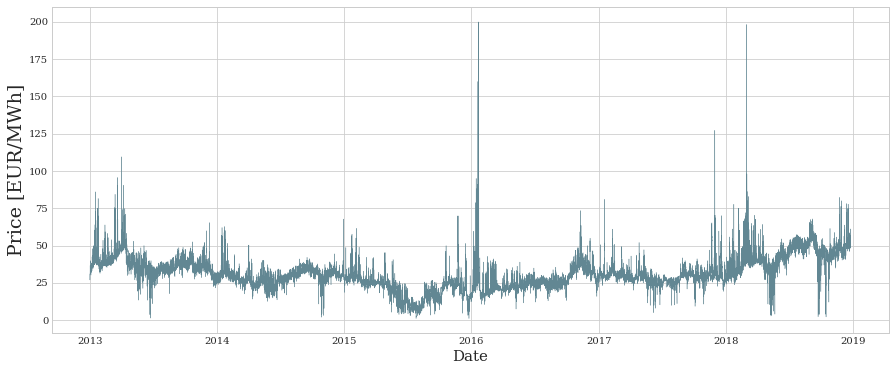

In [ ]:
import multiprocessing

import pandas as pd
from neuralforecast.data.datasets.epf import EPF
from neuralforecast.data.tsloader import TimeSeriesLoader

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 19

# Load and plot data
Y_df, X_df, S_df = EPF.load_groups(directory='./data', groups=['NP','FR'])

fig = plt.figure(figsize=(15, 6))
plt.plot(Y_df[Y_df['unique_id']=='NP'].ds, Y_df[Y_df['unique_id']=='NP'].y.values, color='#628793', linewidth=0.4)
plt.ylabel('Price [EUR/MWh]', fontsize=19)
plt.xlabel('Date', fontsize=15)
# plt.savefig('./results/NP.png', bbox_inches = 'tight')
plt.show()

### Declare Model and Data Parameters

In [ ]:
# Architecture parameters
mc = {}
mc['model'] = 'nbeats'
mc['mode'] = 'simple'
mc['activation'] = 'ReLU'

mc['n_time_in'] = 24*7
mc['n_time_out'] = 24
mc['n_x_hidden'] = 8
mc['n_s_hidden'] = 0

mc['stack_types'] = 2*['identity']
mc['n_blocks'] = [1, 1]
mc['n_layers'] = [2, 2]

mc['n_hidden'] = 512
mc['shared_weights'] = False
mc['n_harmonics'] = 0
mc['n_polynomials'] = 0

# Optimization and regularization parameters
mc['initialization'] = 'lecun_normal'
mc['learning_rate'] = 0.001
mc['batch_size'] = 256
mc['lr_decay'] = 0.5
mc['lr_decay_step_size'] = 33
mc['max_epochs'] = 1
mc['max_steps'] = None
mc['early_stop_patience'] = 20
mc['eval_freq'] = 500
mc['batch_normalization'] = False
mc['dropout_prob_theta'] = 0
mc['dropout_prob_exogenous'] = 0
mc['l1_theta'] = 0
mc['weight_decay'] = 0
mc['loss_train'] = 'MAE'
mc['loss_hypar'] = 0.5
mc['loss_valid'] = mc['loss_train']
mc['random_seed'] = 1

# Data Parameters
mc['idx_to_sample_freq'] = 1
mc['val_idx_to_sample_freq'] = 24 * 7
mc['n_val_weeks'] = 52
mc['normalizer_y'] = None
mc['normalizer_x'] = 'median'
mc['complete_windows'] = False
mc['frequency'] = 'H'
mc['seasonality'] = 24

print(65*'=')
print(pd.Series(mc))
print(65*'=')

mc['n_theta_hidden'] = len(mc['stack_types']) * [ [int(mc['n_hidden']), int(mc['n_hidden'])] ]

model                                   nbeats
mode                                    simple
activation                                ReLU
n_time_in                                  168
n_time_out                                  24
n_x_hidden                                   8
n_s_hidden                                   0
stack_types               [identity, identity]
n_blocks                                [1, 1]
n_layers                                [2, 2]
n_hidden                                   512
shared_weights                           False
n_harmonics                                  0
n_polynomials                                0
initialization                    lecun_normal
learning_rate                            0.001
batch_size                                 256
lr_decay                                   0.5
lr_decay_step_size                          33
max_epochs                                  10
max_steps                                 None
early_stop_pa

### Instantiate Loaders and Model

In [ ]:
from neuralforecast.experiments.utils import create_datasets

train_dataset, val_dataset, test_dataset, scaler_y = create_datasets(mc=mc,
                                                                     S_df=S_df, Y_df=Y_df, X_df=X_df,
                                                                     f_cols=['Exogenous1', 'Exogenous2'],
                                                                     ds_in_val=294*24,
                                                                     ds_in_test=728*24)

train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=int(mc['batch_size']),
                                #num_workers=int(min(multiprocessing.cpu_count(), 3)),
                                shuffle=True)

val_loader = TimeSeriesLoader(dataset=val_dataset,
                              batch_size=int(mc['batch_size']),
                              #num_workers=int(min(multiprocessing.cpu_count(), 3)),
                              shuffle=False)

test_loader = TimeSeriesLoader(dataset=test_dataset,
                               batch_size=int(mc['batch_size']),
                               #num_workers=int(min(multiprocessing.cpu_count(), 3)),
                               shuffle=False)

mc['n_x'], mc['n_s'] = train_dataset.get_n_variables()

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
FR        0           2014-03-16 2016-12-31 23:00:00
          1           2011-01-09 2014-03-15 23:00:00
NP        0           2016-03-08 2018-12-24 23:00:00
          1           2013-01-01 2016-03-07 23:00:00
INFO:root:
Total data 			104832 time stamps 
Available percentage=100.0, 	104832 time stamps 
Insample  percentage=53.21, 	55776 time stamps 
Outsample percentage=46.79, 	49056 time stamps 

/Users/cchallu/NIXTLA/neuralforecast/neuralforecast/data/tsdataset.py:208: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(['unique_id', 'ds'], 1, inplace=True)
INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min          

In [ ]:
model = NBEATS(n_time_in=int(mc['n_time_in']),
               n_time_out=int(mc['n_time_out']),
               n_x=mc['n_x'],
               n_s=mc['n_s'],
               n_s_hidden=int(mc['n_s_hidden']),
               n_x_hidden=int(mc['n_x_hidden']),
               shared_weights=mc['shared_weights'],
               initialization=mc['initialization'],
               activation=mc['activation'],
               stack_types=mc['stack_types'],
               n_blocks=mc['n_blocks'],
               n_layers=mc['n_layers'],
               n_theta_hidden=mc['n_theta_hidden'],
               n_harmonics=int(mc['n_harmonics']),
               n_polynomials=int(mc['n_polynomials']),
               batch_normalization = mc['batch_normalization'],
               dropout_prob_theta=mc['dropout_prob_theta'],
               learning_rate=float(mc['learning_rate']),
               lr_decay=float(mc['lr_decay']),
               lr_decay_step_size=float(mc['lr_decay_step_size']),
               weight_decay=mc['weight_decay'],
               loss_train=mc['loss_train'],
               loss_hypar=float(mc['loss_hypar']),
               loss_valid=mc['loss_valid'],
               frequency=mc['frequency'],
               seasonality=int(mc['seasonality']),
               random_seed=int(mc['random_seed']))

### Train Model

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", 
                               min_delta=1e-4, 
                               patience=mc['early_stop_patience'],
                               verbose=False,
                               mode="min")

trainer = pl.Trainer(max_epochs=mc['max_epochs'], 
                     max_steps=mc['max_steps'],
                     gradient_clip_val=1.0,
                     progress_bar_refresh_rate=10, 
                     log_every_n_steps=500, 
                     check_val_every_n_epoch=1,
                     callbacks=[early_stopping])

trainer.fit(model, train_loader, val_loader)

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:49: LightningDeprecationWarning: Setting `max_steps = None` is deprecated in v1.5 and will no longer be supported in v1.7. Use `max_steps = -1` instead.
  "Setting `max_steps = None` is deprecated in v1.5 and will no longer be supported in v1.7."
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, use

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/pytho

Epoch 9: 100%|██████████| 2/2 [00:12<00:00,  6.32s/it, loss=8.51, v_num=21, train_loss_step=7.300, val_loss=6.030, train_loss_epoch=7.300]


### Make Predictions

In [ ]:
model.return_decomposition = True
outputs = trainer.predict(model, val_loader)

print("outputs[0][0].shape", outputs[0][0].shape)
print("outputs[0][1].shape", outputs[0][1].shape)
print("outputs[0][2].shape", outputs[0][2].shape)

/Users/cchallu/NIXTLA/neuralforecast/neuralforecast/data/tsloader.py:47: UserWarning: This class wraps the pytorch `DataLoader` with a special collate function. If you want to use yours simply use `DataLoader`. Removing collate_fn
  'This class wraps the pytorch `DataLoader` with a '
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]
outputs[0][0].shape torch.Size([84, 24])
outputs[0][1].shape torch.Size([84, 24])
outputs[0][2].shape torch.Size([84, 3, 24])


# Forecast

In [ ]:
Y_forecast_df = Y_df[Y_df['ds']<'2016-12-27']
Y_forecast_df.tail()

,unique_id,ds,y
87355,NP,2016-12-26 19:00:00,27.44
87356,NP,2016-12-26 20:00:00,27.11
87357,NP,2016-12-26 21:00:00,26.82
87358,NP,2016-12-26 22:00:00,26.65
87359,NP,2016-12-26 23:00:00,25.68


In [ ]:
X_forecast_df = X_df[X_df['ds']<'2016-12-28']
X_forecast_df.tail()

,unique_id,ds,Exogenous1,Exogenous2,week_day,day_0,day_1,day_2,day_3,day_4,day_5,day_6
87379,NP,2016-12-27 19:00:00,0.133135,-0.566365,-0.67449,0.0,1.927498,0.0,0.0,0.0,0.0,0.0
87380,NP,2016-12-27 20:00:00,0.010193,-0.569435,-0.67449,0.0,1.927498,0.0,0.0,0.0,0.0,0.0
87381,NP,2016-12-27 21:00:00,-0.088980,-0.572021,-0.67449,0.0,1.927498,0.0,0.0,0.0,0.0,0.0
87382,NP,2016-12-27 22:00:00,-0.221603,-0.576345,-0.67449,0.0,1.927498,0.0,0.0,0.0,0.0,0.0
87383,NP,2016-12-27 23:00:00,-0.426087,-0.583618,-0.67449,0.0,1.927498,0.0,0.0,0.0,0.0,0.0


In [ ]:
model.return_decomposition = False
forecast_df = model.forecast(Y_df=Y_forecast_df, X_df=X_forecast_df, S_df=S_df, batch_size=2)

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/ipykernel_launcher.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
FR        0           2011-01-09 2016-12-26 23:00:00
          1           2016-12-27 2016-12-27 23:00:00
NP        0           2013-01-01 2016-12-26 23:00:00
          1           2016-12-27 2016-12-27 23:00:00
INFO:root:
Total data 			87288 time stamps 
Available percentage=100.0, 	87288 time stamps 
Insample  percentage=0.05, 	48 time stamps 
Outsample percentage=99.95, 	87240 time stamps 

/Users/

Predicting: 100%|██████████| 1/1 [00:00<00:00, 53.28it/s]


In [ ]:
forecast_df

,unique_id,ds,y
0,FR,2016-12-27 00:00:00,44.640026
1,FR,2016-12-27 01:00:00,50.731392
2,FR,2016-12-27 02:00:00,44.564629
3,FR,2016-12-27 03:00:00,44.049648
4,FR,2016-12-27 04:00:00,47.089638
5,FR,2016-12-27 05:00:00,50.541325
6,FR,2016-12-27 06:00:00,52.448578
7,FR,2016-12-27 07:00:00,51.141190
8,FR,2016-12-27 08:00:00,52.997055
9,FR,2016-12-27 09:00:00,53.803757


/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


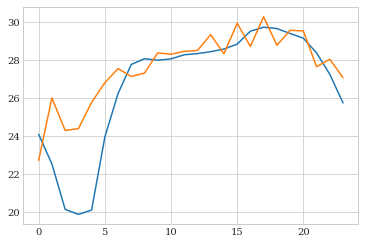

In [ ]:
plt.plot(Y_df[(Y_df['unique_id']=='NP') & (Y_df['ds'].dt.date==pd.Timestamp('2016-12-27'))].y.values)
plt.plot(forecast_df[forecast_df['unique_id']=='NP'].y.values)

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


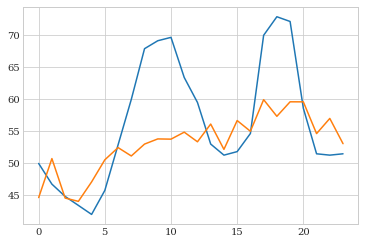

In [ ]:
plt.plot(Y_df[(Y_df['unique_id']=='FR') & (Y_df['ds'].dt.date==pd.Timestamp('2016-12-27'))].y.values)
plt.plot(forecast_df[forecast_df['unique_id']=='FR'].y.values)